# Examples of configuring and running NSGA-II

In [79]:
include("../src/bounds.jl")
include("../src/solution.jl")
include("../src/operator.jl")
include("../src/continuousProblem.jl")
include("../src/binaryProblem.jl")
include("../src/algorithm.jl")
include("../src/component.jl")
include("../src/utils.jl")

using Dates

BinaryProblem(5, Function[var"#761#764"(), var"#762#765"()], Function[], "OneZeroMax")
BinarySolution(BitVector(Bool[0, 1, 1, 1, 0]), Real[0.0, 0.0], Real[], Dict{Any, Any}())
BinarySolution(BitVector(Bool[0, 1, 1, 1, 0]), Real[3, 2], Real[], Dict{Any, Any}())


## Configure the algorithm to solve a continuous problem (Kursawe)

### Indicate the problem to solve

In [81]:
problem = kursaweProblem()

ContinuousProblem{Real}(Bounds{Real}[Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0)  …  Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0)], Function[var"#744#747"(), var"#745#748"{var"#evalG#746"}(var"#evalG#746"())], Function[], "ZDT2")

### A solver contains the algorithm components and parameters

In [82]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

100

In [83]:
solver.solutionsCreation = defaultSolutionsCreation
solver.solutionsCreationParameters = (problem = solver.problem, numberOfSolutionsToCreate = solver.populationSize)

solver.evaluation = sequentialEvaluation
solver.evaluationParameters = (problem = solver.problem, )

solver.termination = terminationByEvaluations
solver.terminationParameters = (numberOfEvaluationToStop = 25000, )

solver.selection = solver.selection = binaryTournamentMatingPoolSelection
solver.selectionParameters = (matingPoolSize = 100, comparator = compareRankingAndCrowdingDistance)

solver.mutation = mutation = polynomialMutation
solver.mutationParameters = (probability=1.0/numberOfVariables(problem), distributionIndex = 20.0, bounds=problem.bounds)

solver.crossover = blxAlphaCrossover
solver.crossoverParameters = (probability = 0.9, alpha = 0.5, bounds=problem.bounds)

(probability = 0.9, alpha = 0.5, bounds = Bounds{Real}[Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0)  …  Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0), Bounds{Real}(0.0, 1.0)])

### Run the algorithm

In [84]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 1884 milliseconds


### Print the results

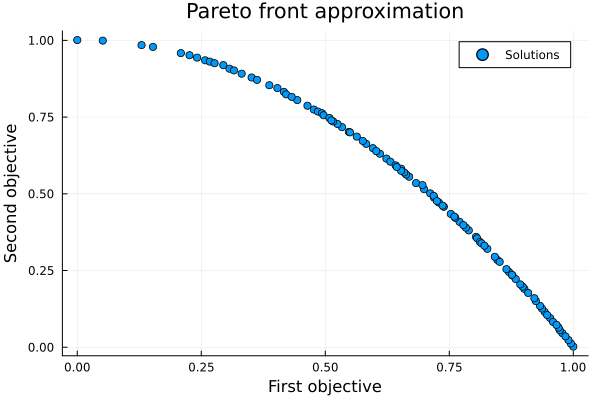

In [85]:
using Plots
 
#data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")

## Configure the algorithm to solve a binary problem (OneZeroMax)

In [71]:
problem = oneZeroMax(512)

BinaryProblem(512, Function[var"#551#554"(), var"#552#555"()], Function[], "OneZeroMax")

In [72]:
solver::NSGAII = NSGAII()
solver.problem = problem
solver.populationSize = 100

100

In [73]:
solver.solutionsCreation = defaultSolutionsCreation
solver.solutionsCreationParameters = (problem = solver.problem, numberOfSolutionsToCreate = solver.populationSize)

solver.evaluation = sequentialEvaluation
solver.evaluationParameters = (problem = solver.problem, )

solver.termination = terminationByEvaluations
solver.terminationParameters = (numberOfEvaluationToStop = 25000, )

solver.selection = solver.selection = binaryTournamentMatingPoolSelection
solver.selectionParameters = (matingPoolSize = 100, comparator = compareRankingAndCrowdingDistance)

solver.mutation = bitFlipMutation
solver.mutationParameters = (probability=1.0/numberOfVariables(problem),)

solver.crossover = singlePointCrossover
solver.crossoverParameters = (probability = 0.9, )

(probability = 0.9,)

In [74]:
startingTime = Dates.now()
optimize(solver)
endTime = Dates.now()

println("Computing time: ", (endTime - startingTime))

Computing time: 1597 milliseconds


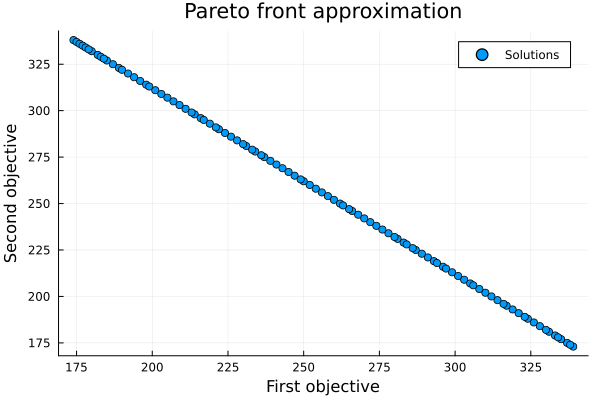

In [75]:
#data to plot
x = [solution.objectives[1] for solution in solver.foundSolutions];
y = [solution.objectives[2] for solution in solver.foundSolutions];
 
gr();
 
scatter(x, y,  title = "Pareto front approximation", label = "Solutions")
xlabel!("First objective")
ylabel!("Second objective")